In [1]:
from dask.distributed import Client, LocalCluster, progress
import dask.dataframe as dd
import dask.array as da
import seaborn as sns

In [2]:
cluster = LocalCluster()
c = Client(cluster) #Client('dask-scheduler:8786')
c

Client Scheduler: tcp://127.0.0.1:54105,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


In [3]:
df = dd.read_csv('data/train.tsv', sep='\t').persist()
#df.set_index('train_id')
progress(df)

VBox()

In [4]:
df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 8 entries, train_id to item_description
dtypes: object(4), float64(1), int64(3)

In [5]:
%time df.set_index('train_id').head()

CPU times: user 370 ms, sys: 62.5 ms, total: 433 ms
Wall time: 5.03 s


,name,item_condition_id,category_name,brand_name,price,shipping,item_description
train_id,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [6]:
df.columns.value_counts()

brand_name           1
item_condition_id    1
price                1
name                 1
shipping             1
train_id             1
category_name        1
item_description     1
dtype: int64

# Clean the data

Set a flag for missing data. **Category, description and brand** are the fields considered as relevant.



In [7]:
df['brand_name'] = df['brand_name'].fillna('NotSet')
df['category_name'] = df['category_name'].fillna('NotSet')
df['item_description'] = df['item_description'].mask(
    df['item_description'] == 'No description yet', 'NotSet')

In [8]:
#import pandas as pd
#df = pd.read_csv('data/train.tsv', sep='\t', index_col='train_id')
# Electronics/Video Games & Consoles/Games
df_electronics_game = df[df['category_name'].str.contains('Video Game')]
df_electronics = df[df['category_name'] == 'Electronics/Video Games & Consoles/Games']
df_electronics.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
91,91,Goosebumps HorrorLand DS Game,3,Electronics/Video Games & Consoles/Games,Nintendo,10.0,0,Good used condition. Ask about bundling to save.
177,177,NBA 2k14 BRAND NEW SEALED,1,Electronics/Video Games & Consoles/Games,Sony,6.0,1,I am a first time seller located in California...
233,233,Rockstar Bundle (Xbox 360 / One),1,Electronics/Video Games & Consoles/Games,Xbox,38.0,1,Brand New! Factory Sealed! Fast & Free Shippin...
237,237,Lego Harry Potter Years 1-4 Wii,2,Electronics/Video Games & Consoles/Games,Nintendo,19.0,0,Lego Harry Potter Years 1-4 Wii E10+ Warner Br...
276,276,Nintendo 64,3,Electronics/Video Games & Consoles/Games,Nintendo,124.0,0,Here I have a Nintendo 64 old school Everythin...


#### Is "Video Game" a token relevant for all other related categories?

In [9]:
df_electronics_game['category_name'].unique().reset_index().compute()

,index,category_name
0,0,Electronics/Video Games & Consoles/Consoles
1,1,Electronics/Video Games & Consoles/Games
2,2,Electronics/Video Games & Consoles/Video Gamin...
3,3,Vintage & Collectibles/Electronics/Video Game
4,4,Electronics/Video Games & Consoles/Accessories
5,5,Electronics/Video Games & Consoles/Other
6,6,Electronics/Video Games & Consoles/Strategy Gu...
7,7,Electronics/Video Games & Consoles/Replacement...


* How does "Electronics/Video Games & Consoles/Games", our main category, relate to a more generalized subset using the mentioned token "Video Game" in the cae of missing data?

In [17]:
df_electronics_brands = df_electronics[[
    'train_id', 'brand_name'
]].groupby(
    'brand_name'
).count().compute().sort_values(
    by='train_id', ascending=False)



In [18]:
df_electronics_brands_game = df_electronics_game[[
    'train_id', 'brand_name'
]].groupby(
    'brand_name'
).count().compute().sort_values(
    by='train_id', ascending=False)



distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:54141 remote=tcp://127.0.0.1:54105>


In [19]:
df_not_set_electronics = df_electronics[(df_electronics.item_description == 'NotSet') | (df_electronics.brand_name == 'NotSet')]
df_not_set_electronics['item_description'] = df_not_set_electronics['item_description'].mask(
    df_not_set_electronics['item_description'] != 'NotSet', 'IsSet')


df_not_set_electronics = df_not_set_electronics[[
    'train_id', 'brand_name', 'item_description'
]].groupby([
    'brand_name', 'item_description'
]).count()

df_not_set_electronics.compute().sort_values(
    by='train_id', ascending=False)

,,train_id
brand_name,item_description,
NotSet,IsSet,6032
Nintendo,NotSet,873
NotSet,NotSet,674
Sony,NotSet,461
Xbox,NotSet,401
Microsoft,NotSet,13
Konami,NotSet,4
PlayStation,NotSet,4
VTech,NotSet,2


In [58]:
df_not_set_electronics_game = df_electronics_game[(df_electronics_game.item_description == 'NotSet') | (df_electronics_game.brand_name == 'NotSet')]
df_not_set_electronics_game['item_description'] = df_not_set_electronics_game['item_description'].mask(
    df_not_set_electronics_game['item_description'] != 'NotSet', 'IsSet')


df_not_set_electronics_game = df_not_set_electronics_game[[
    'train_id', 'brand_name', 'item_description'
]].groupby([
    'brand_name', 'item_description'
]).count()

df_not_set_electronics_game.compute().sort_values(
    by='train_id', ascending=False)

,,train_id
brand_name,item_description,
NotSet,IsSet,8948
Nintendo,NotSet,1093
NotSet,NotSet,896
Sony,NotSet,553
Xbox,NotSet,508
Microsoft,NotSet,22
Razer,NotSet,5
PlayStation,NotSet,4
Konami,NotSet,4


In [84]:
df_not_set_electronics_reset = df_not_set_electronics.reset_index()
df_not_set_electronics_reset[
    df_not_set_electronics_reset.brand_name == 'NotSet'
].sum().compute() ['train_id'] * 100 / len(df_electronics)

25.251346161087472

In [86]:
df_not_set_electronics_game_reset = df_not_set_electronics_game.reset_index()
df_not_set_electronics_game_reset[
    df_not_set_electronics_game_reset.brand_name == 'NotSet'
].sum().compute() ['train_id'] * 100 / len(df_electronics_game)

25.633414056193526

  * Brand name is a significant part of the dataset, and NotSet one the most representatives
  * Using "Video Game" token gives a proportional quantity of NotSet brands then the original category


* Item description misses mostly from items that have a brand name set
* NotSet brand is as representative as the most popular brands where no description is set 

Are videogamers the least keen on setting a description? However, it seems like for all items with brand NotSet there is a description.

How does it look in general?

In [21]:
df_not_set = df[(df.item_description == 'NotSet') | (df.brand_name == 'NotSet')]
df_not_set['item_description'] = df_not_set['item_description'].mask(
    df_not_set['item_description'] != 'NotSet', 'IsSet')


df_not_set_brand_description = df_not_set[[
    'train_id', 'brand_name', 'item_description'
]].groupby([
    'brand_name', 'item_description'
]).count()

df_not_set_brand_description.compute().sort_values(
    by='train_id', ascending=False)

train_id
brand_name           item_description          
NotSet               IsSet               595309
                     NotSet               37373
Nike                 NotSet                2873
LuLaRoe              NotSet                2864
PINK                 NotSet                2664
Rae Dunn             NotSet                1829
Victoria's Secret    NotSet                1728
Nintendo             NotSet                1135
FOREVER 21           NotSet                1125
Apple                NotSet                 814
American Eagle       NotSet                 676
Funko                NotSet                 617
Adidas               NotSet                 600
Sony                 NotSet                 577
Michael Kors         NotSet                 561
Disney               NotSet                 539
Bath & Body Works    NotSet                 520
Under Armour         NotSet                 519
Xbox                 NotSet                 512
Coach                NotSet                 434
Hollister            NotSet                 432
Old Navy             NotSet                 417
Brandy Melville      NotSet                 401
SeneGence            NotSet                 379
Lululemon            NotSet                 334
Charlotte Russe      NotSet                 292
Polo Ralph Lauren    NotSet                 290
H&M                  NotSet                 277
Carter's             NotSet                 254
The North Face       NotSet                 253
...                                         ...
ESPN                 NotSet                   1
Easel                NotSet                   1
Elemis Ltd           NotSet                   1
Elizavecca           NotSet                   1
Elliott Lucca        NotSet                   1
Emerald Sundae       NotSet                   1
Emerson              NotSet                   1
Cliff Keen           NotSet                   1
Claudia Richard      NotSet                   1
Citizens of Humanity NotSet                   1
Band of Gypsies      NotSet                   1
Annabelle            NotSet                   1
Apostrophe           NotSet                   1
Aquatopia            NotSet                   1
Arm & Hammer         NotSet                   1
Armani Collezioni    NotSet                   1
Aroma                NotSet                   1
As Seen on TV        NotSet                   1
Dermablend           NotSet                   1
Banzai               NotSet                   1
Christian Audigier   NotSet                   1
Belif                NotSet                   1
Benefit Cosmetics    NotSet                   1
Boho Chic            NotSet                   1
Buffalo              NotSet                   1
DeLonghi             NotSet                   1
Calphalon            NotSet                   1
Canada Goose         NotSet                   1
Catherine Malandrino NotSet                   1
gDiapers             NotSet                   1

[1780 rows x 1 columns]

* NoSet descriptions and brands are the most common elements


# Transform the data

* Some brands from elecctronics reappear with more items. 
  * Are they categorized wrongly?
  * Is it feasible or necessary to recompute the dataset and reassign the category of items based on the category with most items?

In [22]:
df_not_set_cat = df_not_set[(df_not_set.brand_name == 'Nintendo') | (df_not_set.brand_name == 'Sony')][[
    'train_id', 'brand_name', 'category_name', 'item_description'
]].groupby([
    'category_name', 'brand_name', 'item_description'
]).count()

df_not_set_cat.compute().sort_values(
    by='train_id', ascending=False)

train_id
category_name                                      brand_name item_description          
Electronics/Video Games & Consoles/Games           Nintendo   NotSet                 873
                                                   Sony       NotSet                 461
Vintage & Collectibles/Electronics/Video Game      Nintendo   NotSet                  67
Electronics/Video Games & Consoles/Accessories     Nintendo   NotSet                  66
Electronics/Video Games & Consoles/Consoles        Nintendo   NotSet                  53
Vintage & Collectibles/Electronics/Video Game      Sony       NotSet                  36
Electronics/Video Games & Consoles/Video Gaming... Nintendo   NotSet                  33
Electronics/Video Games & Consoles/Accessories     Sony       NotSet                  30
Electronics/Video Games & Consoles/Consoles        Sony       NotSet                  14
Kids/Toys/Games                                    Nintendo   NotSet                  11
Electronics/Video Games & Consoles/Video Gaming... Sony       NotSet                  11
Kids/Toys/Action Figures & Statues                 Nintendo   NotSet                   5
NotSet                                             Nintendo   NotSet                   4
Electronics/TV, Audio & Surveillance/Headphones    Sony       NotSet                   3
Electronics/TV, Audio & Surveillance/Portable A... Sony       NotSet                   3
Electronics/Cameras & Photography/Digital Cameras  Sony       NotSet                   3
Men/Men's Accessories/Hats                         Nintendo   NotSet                   3
Kids/Toys/Stuffed Animals & Plush                  Sony       NotSet                   2
Kids/Toys/Hobbies                                  Nintendo   NotSet                   2
Electronics/Cameras & Photography/Camcorders       Sony       NotSet                   2
Electronics/Cell Phones & Accessories/Chargers ... Nintendo   NotSet                   2
Electronics/TV, Audio & Surveillance/Headphones    Nintendo   NotSet                   2
Electronics/Cell Phones & Accessories/Cases, Co... Nintendo   NotSet                   2
Kids/Toys/Stuffed Animals & Plush                  Nintendo   NotSet                   2
Electronics/Car Audio, Video & GPS/Other           Sony       NotSet                   1
Kids/Toys/Arts & Crafts                            Nintendo   NotSet                   1
Kids/Toys/Games                                    Sony       NotSet                   1
Vintage & Collectibles/Trading Cards/Animation     Nintendo   NotSet                   1
Men/Men's Accessories/Wallets                      Nintendo   NotSet                   1
Women/Other/Other                                  Sony       NotSet                   1
Electronics/Cell Phones & Accessories/Chargers ... Sony       NotSet                   1
Electronics/Video Games & Consoles/Strategy Guides Sony       NotSet                   1
Vintage & Collectibles/Collectibles/Figurine       Nintendo   NotSet                   1
Vintage & Collectibles/Electronics/Game            Sony       NotSet                   1
Electronics/TV, Audio & Surveillance/DVD & Blu-... Sony       NotSet                   1
Other/Office supplies/Electronics                  Sony       NotSet                   1
Men/Shoes/Athletic                                 Nintendo   NotSet                   1
Kids/Toys/Dolls & Accessories                      Nintendo   NotSet                   1
Other/Musical instruments/DJ, Electronic Music ... Sony       NotSet                   1
Home/Artwork/Posters & Prints                      Nintendo   NotSet                   1
Electronics/Video Games & Consoles/Strategy Guides Nintendo   NotSet                   1
Electronics/Car Audio, Video & GPS/Car Stereos ... Sony       NotSet                   1
Electronics/Computers & Tablets/Drives, Storage... Sony       NotSet                   1
Electronics/Cell Phones & Accessories/Cell Phon... Sony       NotSet       

# Summary

,brand_name,train_id_x,train_id_y,change
0,Nintendo,10044,14591,0.452708
1,NotSet,6706,9844,0.467939
2,Sony,5381,7445,0.383572
3,Xbox,4046,5656,0.397924
4,Microsoft,211,514,1.436019


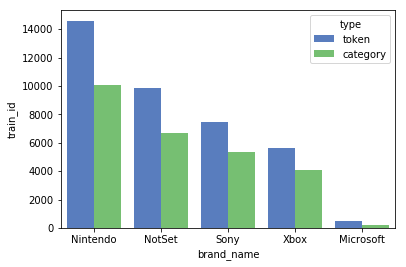

In [37]:
df_pct_diff = dd.merge(
    df_electronics_brands.head().reset_index(), df_electronics_brands_game.head().reset_index(), 
    on='brand_name'
)

df_electronics_brands_type = df_electronics_brands.copy().head()
df_electronics_brands_type['type'] = 'category'

df_electronics_brands_game_type = df_electronics_brands_game.copy().head()
df_electronics_brands_game_type['type'] = 'token'

merged_brands = dd.concat(
    [df_electronics_brands_game_type.reset_index(), df_electronics_brands_type.reset_index()],
    interleave_partitions=True, axis=0
).compute()

df_pct_diff['change'] = df_pct_diff[['train_id_x', 'train_id_y']].pct_change(axis='columns')['train_id_y']

sns.barplot(
    x="brand_name", y='train_id', hue="type", data=merged_brands,
    palette="muted"
)
df_pct_diff



* "Video Game" token can provide valuable information for price prediction.

In [59]:
df_not_set_electronics_game['train_id'].sum().compute() * 100 / len(df_electronics_game)

31.390776762232118

In [67]:
df_not_set_cat_rest = df_not_set[
    ~(df_not_set['category_name'].str.contains('Video Game'))
][[
    'train_id', 'brand_name', 'category_name', 'item_description'
]].groupby([
    'category_name', 'brand_name', 'item_description'
]).count()

#df_not_set_cat_rest.compute().sort_values(
#    by='train_id', ascending=False)

df_not_set_cat_rest['train_id'].sum().compute() * 100 / len(df[~(df['category_name'].str.contains('Video Game'))])

46.09987175687541

* It turns out that videogamers are more diligent filling the information for their items.